# An Overview of the CTC

## Markov Models

To start with this we need to introduce

In [1]:
import torch
from torch import nn

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# plt.style.use("seaborn")
sns.set()


In [46]:

def get_rand(shape=(20, 5)):
    shape = (shape[0], 1, shape[1])
    return torch.rand(*shape)


def get_flattish(shape=(20, 5)):
    shape = (shape[0], 1, shape[1])
    d = torch.rand(*shape) * 0.01
    return d
    

def get_bump(shape=(20, 5), big_activ = (1,12), bump=10, flat=False):
    shape = (shape[0], 1, shape[1])
    d = torch.rand(*shape) 
    if flat:
        d *= 0.1
    d[big_activ[1]][0][big_activ[0]] += bump
    return d

hval = {}
    
def dhook(grad):
    global hval
    hval["dgrad"] = grad
    return grad

def get_simple_ctc_grads(data, target=None):
    T, N, C = data.shape
    data = data.requires_grad_(True)
    ctcloss = nn.CTCLoss()
    if not target: 
        target = torch.arange(1, C)
    inlen = torch.IntTensor([T])
    target_len = torch.IntTensor([len(target)])
    
#     print(T, N, C)
#     print(target, inlen, target_len)

    global hval
    hval = {}
    data.register_hook(dhook)
    loss = ctcloss(data.log_softmax(2), target, inlen, target_len)
    loss.backward()
    
    initial = data.softmax(2).squeeze(1).T.detach().numpy()
    grad = hval["dgrad"].squeeze(1).T.detach().numpy()
    return initial, grad


def posteriorgram(data, xlab, ylab, title, **kwargs):
    sns.heatmap(data, cmap="YlGnBu", cbar=True, **kwargs)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.gca().invert_yaxis()

def double_posterior(dat, gradient):
    plt.figure(figsize=(18,14))
    plt.subplot(211)
    posteriorgram(dat, "Time", "Phones", "Activations")
    plt.subplot(212)
    posteriorgram(gradient, "Time", "Phones", "Gradient")

    

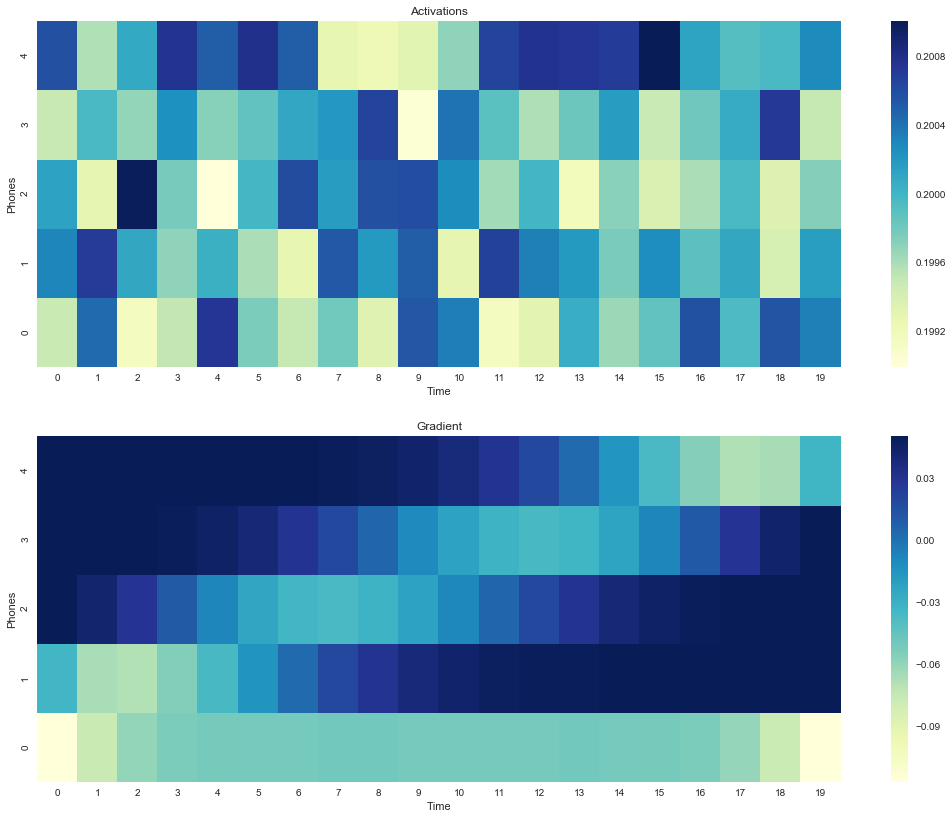

In [36]:
d = get_flattish()
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

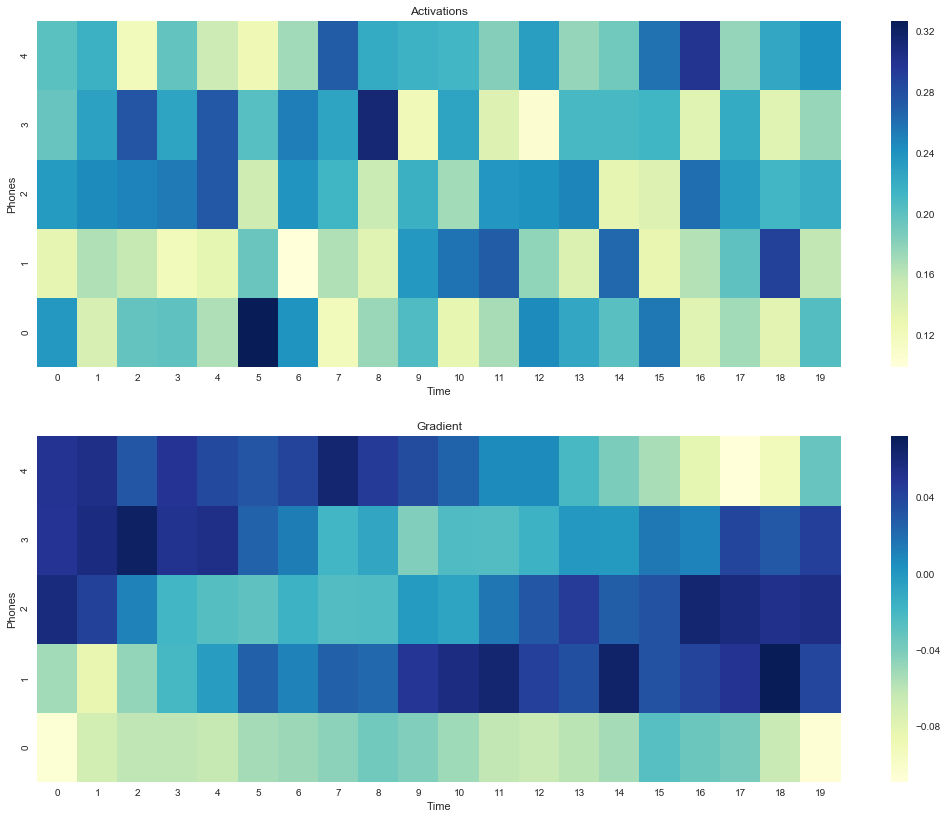

In [37]:
d = get_rand()
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

## Sensitivity to Starting Conditions

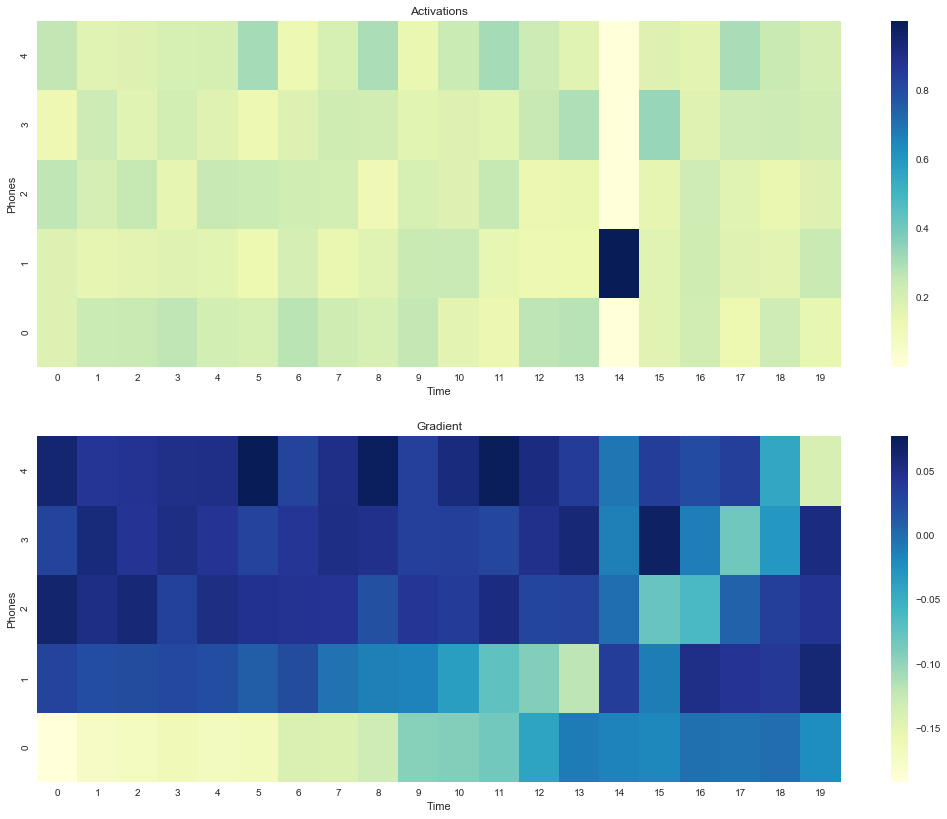

In [38]:

d = get_bump(big_activ=(1, 14), bump=10 )
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

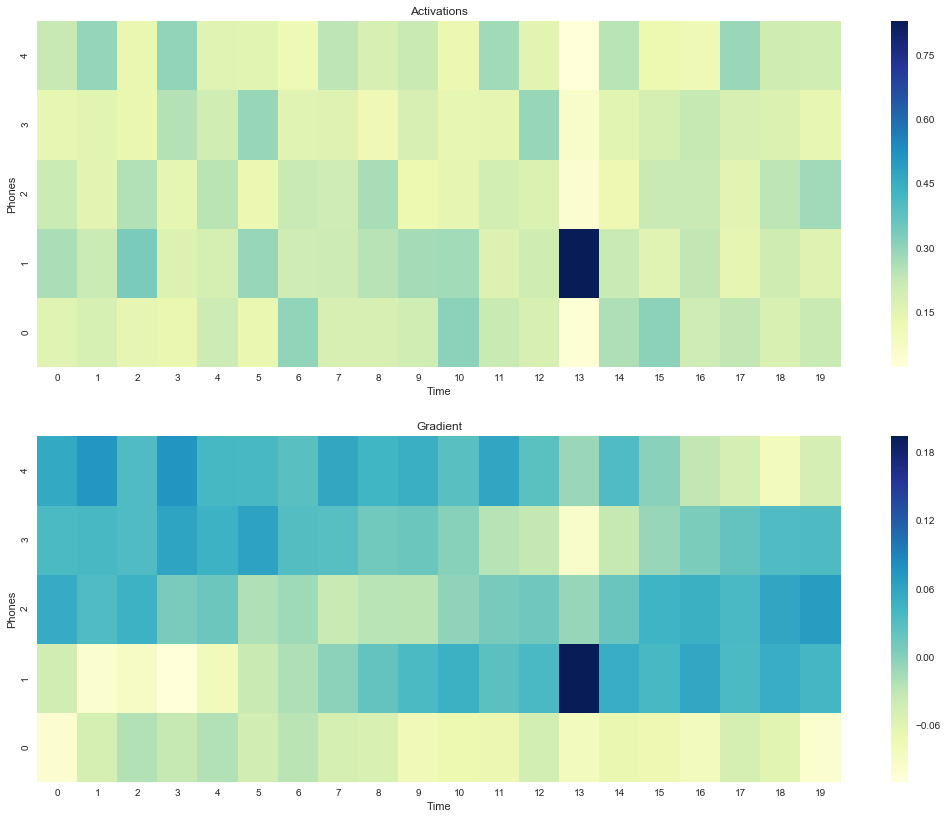

In [39]:
# but  not always
d = get_bump(big_activ=(1, 13), bump=3)
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

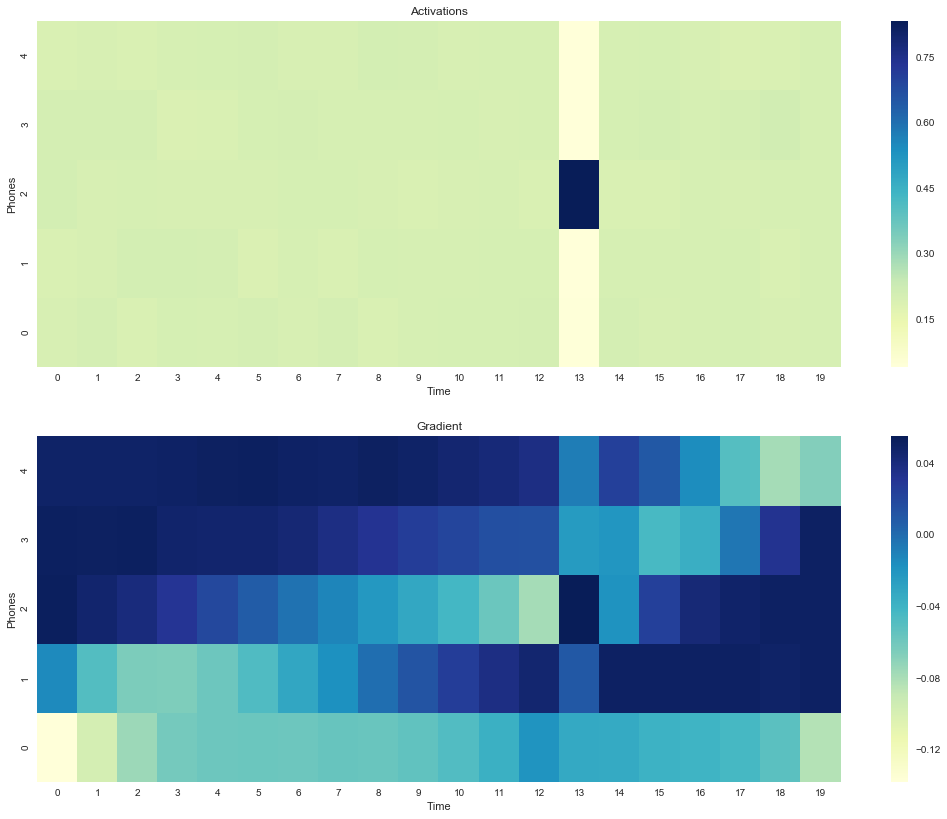

In [40]:
# position matters!
d = get_bump(big_activ=(2, 13), bump=3, flat=True )
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

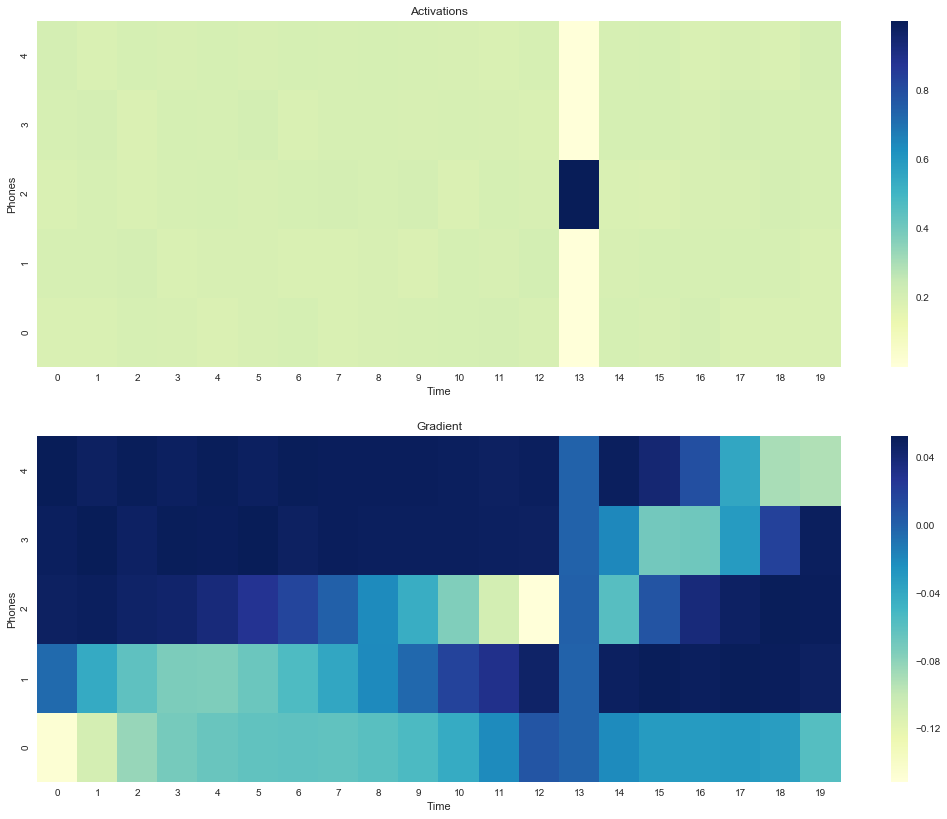

In [41]:
# makes paths slightly tighter though
d = get_bump(big_activ=(2, 13), bump=10, flat=True )
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

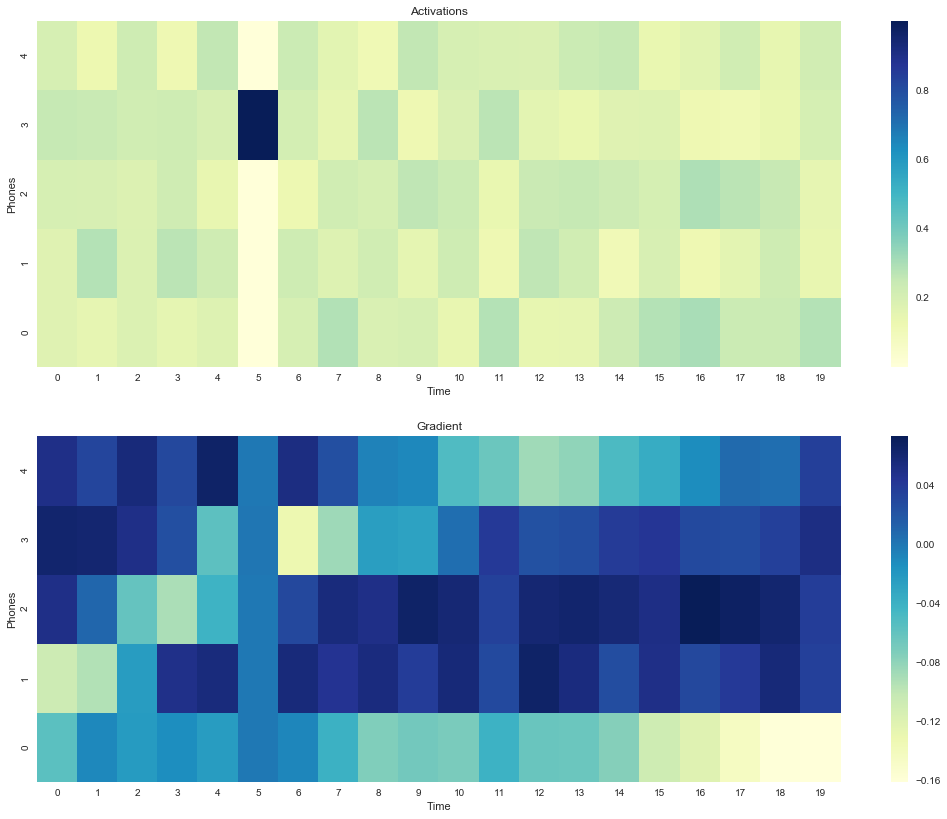

In [42]:
# works both ways!
d = get_bump(big_activ=(3, 5), bump=10 )
initial, grad = get_simple_ctc_grads(d)
double_posterior(initial, grad)

## Poor performance

In [53]:
d_small = get_flattish((4, 5))
d_big = get_flattish((250, 20))

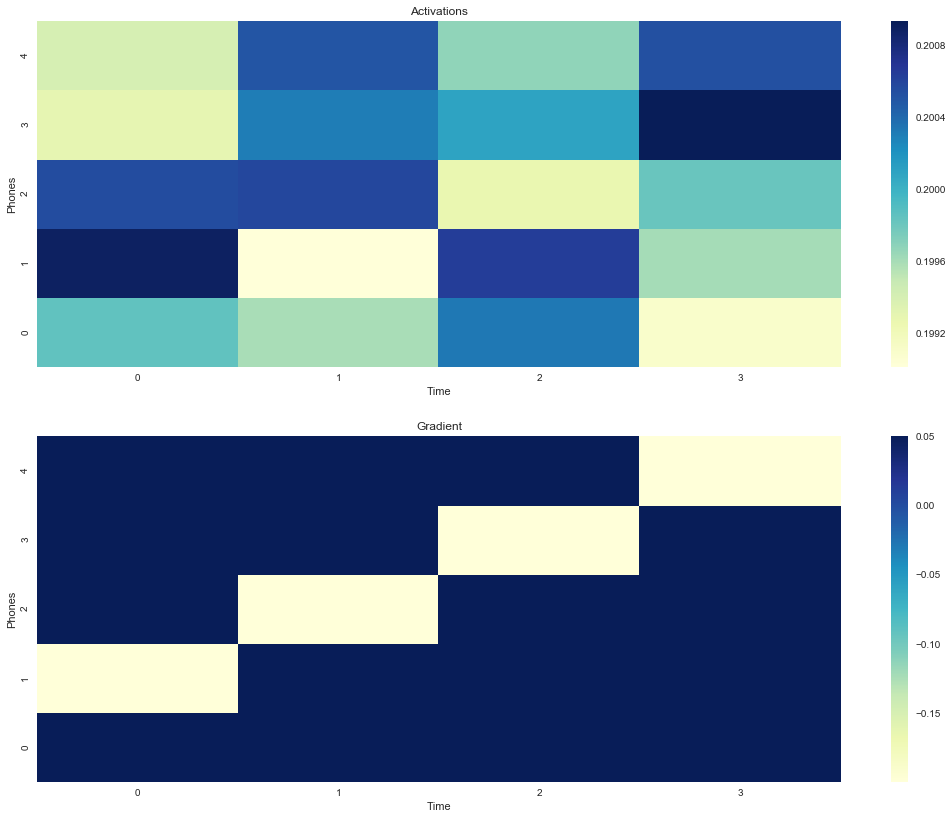

In [54]:
double_posterior(*get_simple_ctc_grads(d_small))

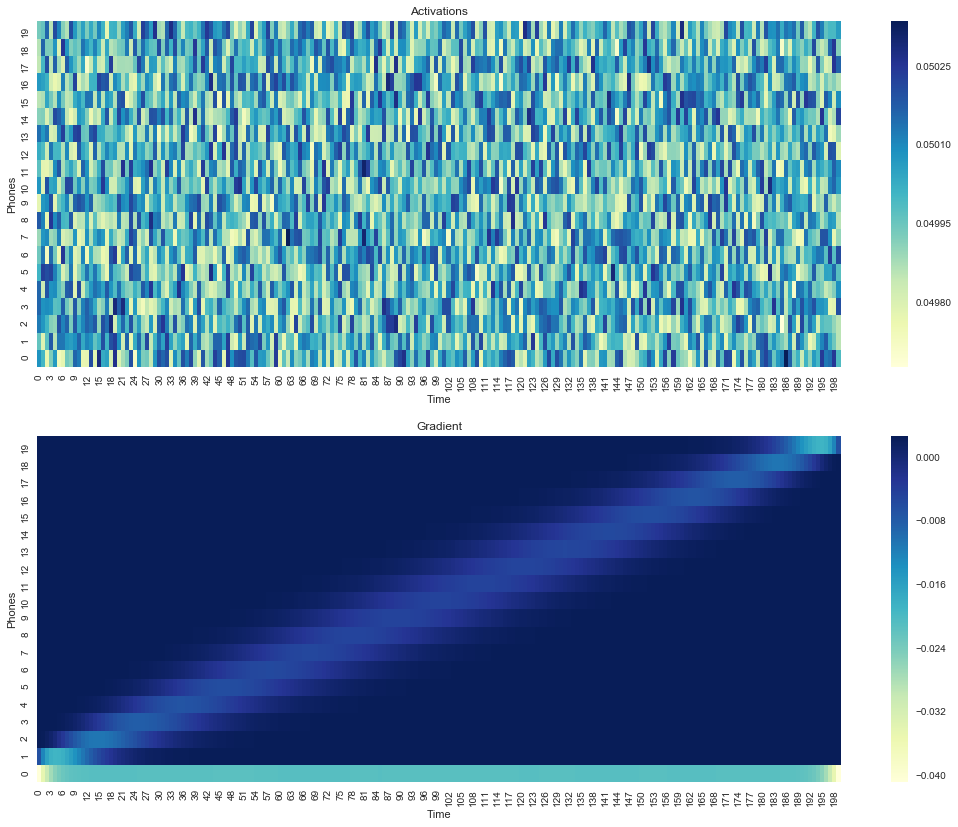

In [55]:
double_posterior(*get_simple_ctc_grads(d_big))

Firstly, we can learn faster from short labels than from longer labels. This should be fairly obvious - consider the combinatoric argument here, in that phone probabilities can only advance or stay the same for each time step. For C states and T timesteps, we have to advance C times and stay the same for T-C times. This gives an ordering of `T!/[C! * (T-C)!].` or Choose(T,C) possible paths. For our above examples

    1. 20 T and 5 States = 1554 paths
    2. 250T and 20 States =  1.7126914e+29 paths

Secondly, given the realisation that we have heavy dependence on initial state, a model that is able to identify certain sounds will be able to learn a lot more than a network that has no idea what it's doing. In this case, the dependence on initial state is an advantage - it is framed as a network that has already learnt some parts of the task, and is now using it's existing knowledge to be more precise.


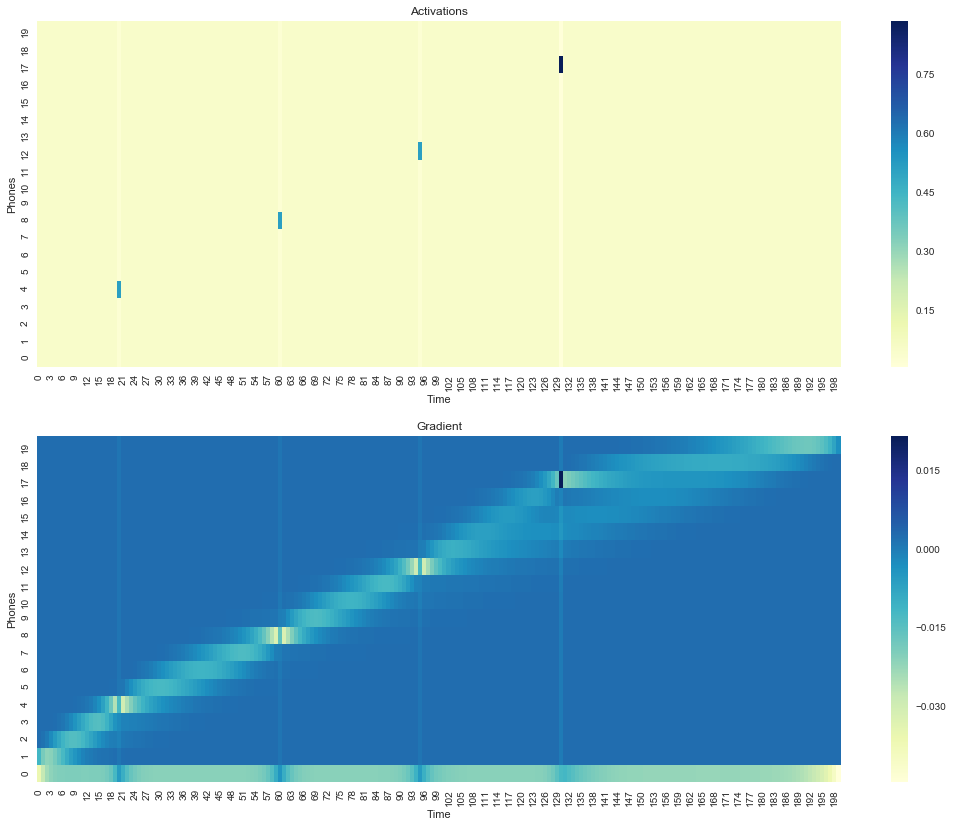

In [64]:
d_big = get_flattish((200, 20))
d_big[20][0][4] += 3
d_big[60][0][8] += 3
d_big[95][0][12] += 3
d_big[130][0][17] += 5
double_posterior(*get_simple_ctc_grads(d_big))

As we can see the gradients here are significantly bigger and we're actually able to effectively reduce the search space and make use of the information.

## Curriculum Learning
This motivates an approach called "curriculum learning" -> we start networks on short sounds and words and graduate to longer words and then finally phrases in a multi-stage training.

For wakeword training, we only want to identify the correct phones. One way of adding more data to our network would be to use a phonetic dictionary we can use to get more words which only contain the necessary phones

In [126]:
GOOG = set("ow k ey g uw g l".split())
ALEXA = set("aa l ih k s aa".split())
DB = set("l ih s n d oh l b iy".split())  # "Listen Dolby"

In [129]:
def get_wordlist(phones):
    with open("beep-1.0") as f:
        for line in f:
            word, *wph = line.split()
            if word.isalpha() and len(wph)>1:
                if not (set(wph) - phones):
                    # i.e. no extra phones
                    yield word.lower(), wph

In [130]:
dbl = sorted(get_wordlist(DB), key=lambda k: len(k[1]))
amaz = sorted(get_wordlist(ALEXA), key=lambda k: len(k[1]))
alphabet = sorted(get_wordlist(GOOG), key=lambda k: len(k[1]))

In [131]:
import random

In [134]:
print(len(dbl))
random.sample(dbl, 10)

288


[('nonce', ['n', 'oh', 'n', 's']),
 ('lease', ['l', 'iy', 's']),
 ('dolly', ['d', 'oh', 'l', 'iy']),
 ('bonded', ['b', 'oh', 'n', 'd', 'ih', 'd']),
 ('snob', ['s', 'n', 'oh', 'b']),
 ('si', ['s', 'iy']),
 ('leaned', ['l', 'iy', 'n', 'd']),
 ('kneel', ['n', 'iy', 'l']),
 ('bonbon', ['b', 'oh', 'n', 'b', 'oh', 'n']),
 ('knob', ['n', 'oh', 'b'])]

In [135]:
print(len(amaz))
random.sample(amaz, 10)

63


[('ark', ['aa', 'k']),
 ('sickle', ['s', 'ih', 'k', 'l']),
 ('kiss', ['k', 'ih', 's']),
 ('clarkes', ['k', 'l', 'aa', 'k', 's']),
 ('sic', ['s', 'ih', 'k']),
 ('chilis', ['k', 'ih', 'l', 'ih', 's']),
 ('lakh', ['l', 'aa', 'k']),
 ('asks', ['aa', 's', 'k', 's']),
 ('lah', ['l', 'aa']),
 ('carsick', ['k', 'aa', 's', 'ih', 'k'])]

In [136]:
print(len(alphabet))
random.sample(alphabet, 10)

51


[('gooley', ['g', 'uw', 'l', 'ey']),
 ('clue', ['k', 'l', 'uw']),
 ('lake', ['l', 'ey', 'k']),
 ('oakley', ['ow', 'k', 'l', 'ey']),
 ('goole', ['g', 'uw', 'l']),
 ('ogle', ['ow', 'g', 'l']),
 ('coke', ['k', 'ow', 'k']),
 ('cloak', ['k', 'l', 'ow', 'k']),
 ('ache', ['ey', 'k']),
 ('kail', ['k', 'ey', 'l'])]

## The blank label

In [74]:
from torch import nn
class NoBlank(nn.Module):
    def forward(self, x):
        T, N, C = x.shape
        newt = torch.zeros(T, N, 1)
        return torch.cat((newt, x), -1)

    def backward(self, grad_output):
        return grad_output[:, :, 1:]


In [141]:
def get_noblank_grads(data, target=None):
    T, N, C = data.shape
    data = data.requires_grad_(True)
    ctcloss = nn.CTCLoss()
    if not target: 
        target = torch.arange(1, C+1)
    inlen = torch.IntTensor([T])
    target_len = torch.IntTensor([len(target)])
    
#     print(T, N, C)
#     print(target, inlen, target_len)

    global hval
    hval = {}
    data.register_hook(dhook)
    m = NoBlank()
    
    loss = ctcloss(m(data.log_softmax(2)), target, inlen, target_len)
    loss.backward()
    
    initial = data.softmax(2).squeeze(1).T.detach().numpy()
    grad = hval["dgrad"].squeeze(1).T.detach().numpy()
    return initial, grad

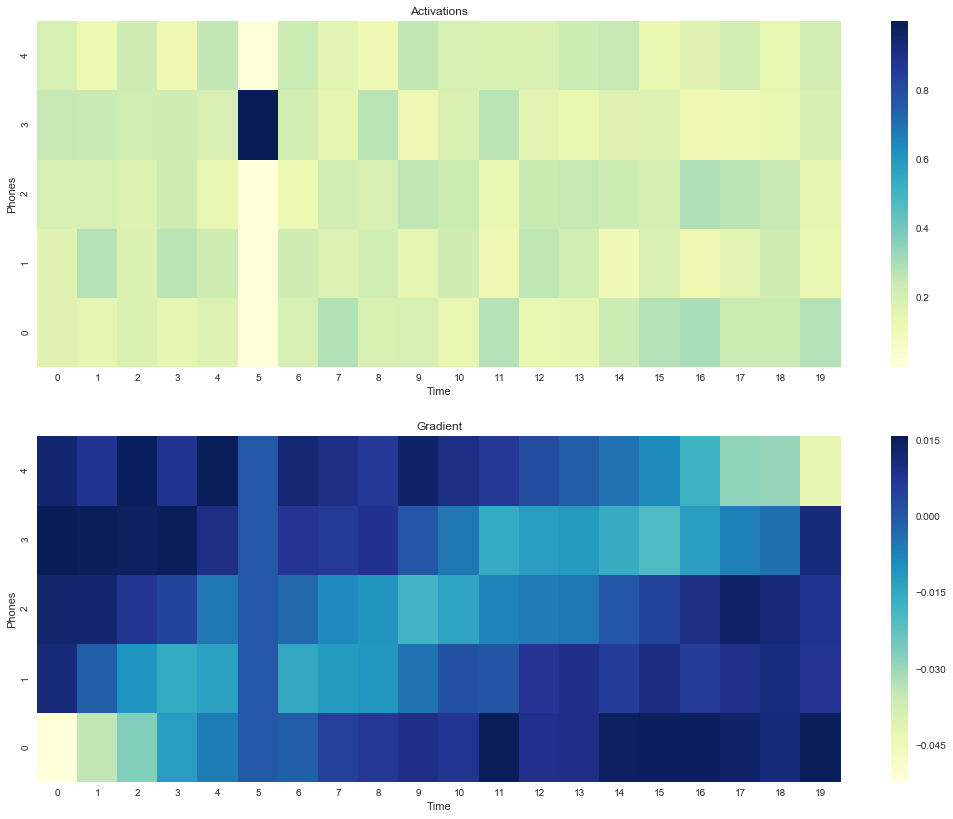

In [142]:
double_posterior(*get_noblank_grads(d))